## Environment setup

In [4]:

import cv2
import os
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from IPython.display import Image
import numpy as np
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import cv2
import colorsys
import random
import numpy as np
import os, random, tensorflow as tf

In [5]:

seed_value=1234
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [6]:
!nvidia-smi

Sun Mar  9 21:31:27 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P3              8W /   37W |      19MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
!pip install git+https://github.com/sunsmarterjie/yolov12.git
!pip install supervision
!pip install flash-attn --no-cache-dir
!pip install huggingface_hub
import cv2
from ultralytics import YOLO
import supervision as sv

  Cloning https://github.com/sunsmarterjie/yolov12.git to c:\users\manus\appdata\local\temp\pip-req-build-h4vmhgbe
  Resolved https://github.com/sunsmarterjie/yolov12.git to commit 4856283cae896b266fd5be56d99b841bc88e9b29
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/sunsmarterjie/yolov12.git 'C:\Users\Manus\AppData\Local\Temp\pip-req-build-h4vmhgbe'


     ---------------------------------------- 0.0/6.0 MB ? eta -:--:--
     ---------------------------------------- 6.0/6.0 MB 121.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      
      
      torch.__version__  = 2.5.1
      
      
      C:\Users\Manus\AppData\Local\Temp\pip-install-bwep_z38\flash-attn_d3e75af4f78240d890dac20f77659c18\setup.py:106: UserWarning: flash_attn was requested, but nvcc was not found.  Are you sure your environment has nvcc available?  If you're installing within a container from https://hub.docker.com/r/pytorch/pytorch, only images whose names contain 'devel' will provide nvcc.
        warnings.warn(
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\Manus\AppData\Local\Temp\pip-install-bwep_z38\flash-attn_d3e75af4f78240d890dac20f77659c18\setup.py", line 198, in <module>
          CUDAExtension(
        File "c:\Users\Manus\anaconda3\Lib\site-packages\torch\utils\cpp_exten

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


In [8]:
current_path = os.getcwd()
HOME = os.path.abspath(os.path.join(current_path, '..'))
print(f"HOME path: {HOME}")

HOME path: c:\Manus\DL_project\project


## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

In [9]:
dataset_location = f"{HOME}\\dataset_plates"

In [10]:
print(dataset_location)

c:\Manus\DL_project\project\dataset_plates


In [11]:
# Define the file path
file_path = os.path.join(dataset_location, "data.yaml")

In [12]:
with open(file_path, "r") as f:
    print(f.read())


train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['plates']

roboflow:
  workspace: projectdl-cjfj5
  project: plates_new_dataset
  version: 8
  license: CC BY 4.0
  url: https://universe.roboflow.com/projectdl-cjfj5/plates_new_dataset/dataset/8


## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [14]:
model = YOLO('yolov12n.yaml')

results = model.train(data=f'{dataset_location}/data.yaml',epochs=100,imgsz=640,batch=16)  # ลด batch size


New https://pypi.org/project/ultralytics/8.3.86 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.63  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: task=detect, mode=train, model=yolov12n.yaml, data=c:\Manus\DL_project\project\dataset_plates/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_ma

train: Scanning C:\Manus\DL_project\project\dataset_plates\train\labels.cache... 243 images, 0 backgrounds, 0 corrupt: 100%|██████████| 243/243 [00:00<?, ?it/s]

WARNING  Box and segment counts should be equal, but got len(segments) = 786, len(boxes) = 2391. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning C:\Manus\DL_project\project\dataset_plates\valid\labels.cache... 10 images, 0 backgrounds, 0 corrupt: 100%|██████████| 10/10 [00:00<?, ?it/s]

WARNING  Box and segment counts should be equal, but got len(segments) = 69, len(boxes) = 127. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.08G      5.969      4.512      4.409         62        640: 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.50it/s]

                   all         10        127          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.17G      5.486      3.956      4.111         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]

                   all         10        127          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.18G      4.868      3.317      3.604         57        640: 100%|██████████| 16/16 [00:04<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.58it/s]

                   all         10        127          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.02G      4.055      2.647      3.111         59        640: 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.19it/s]

                   all         10        127          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.15G      3.678      2.193      2.805         42        640: 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.24it/s]

                   all         10        127          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.31G       3.41      1.903      2.609         71        640: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.83it/s]

                   all         10        127          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.07G      3.238      1.814      2.424         31        640: 100%|██████████| 16/16 [00:07<00:00,  2.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.17it/s]

                   all         10        127      0.237      0.268      0.151     0.0237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.24G      3.083      1.671      2.349         88        640: 100%|██████████| 16/16 [00:05<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.41it/s]

                   all         10        127      0.137      0.433      0.114     0.0304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.16G      2.955      1.616      2.263         71        640: 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.68it/s]

                   all         10        127      0.118      0.307     0.0871     0.0192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.26G      2.935      1.602      2.217         41        640: 100%|██████████| 16/16 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.36it/s]

                   all         10        127      0.221      0.252      0.127     0.0236



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.24G      2.864      1.567      2.178         27        640: 100%|██████████| 16/16 [00:04<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.08it/s]

                   all         10        127      0.302      0.585      0.298     0.0738



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100       3.3G      2.695      1.573      2.037         41        640: 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.73it/s]

                   all         10        127      0.391      0.488      0.415       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.12G      2.679      1.493      2.057         46        640: 100%|██████████| 16/16 [00:04<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.87it/s]

                   all         10        127      0.356      0.551      0.399      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100       3.1G      2.573      1.463      1.993         61        640: 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.13it/s]

                   all         10        127      0.429      0.575      0.434      0.122



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.04G      2.491      1.431      1.903         39        640: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.40it/s]

                   all         10        127      0.389      0.646      0.427       0.14



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.32G      2.434      1.403      1.925         20        640: 100%|██████████| 16/16 [00:04<00:00,  3.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.81it/s]

                   all         10        127      0.303      0.567      0.328     0.0897



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.18G      2.476       1.43        1.9         66        640: 100%|██████████| 16/16 [00:04<00:00,  3.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.50it/s]

                   all         10        127      0.389      0.567      0.448      0.134



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.99G      2.348      1.386      1.853         32        640: 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.09it/s]

                   all         10        127      0.239      0.654       0.28     0.0825



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.06G      2.282      1.341      1.834         42        640: 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.67it/s]

                   all         10        127      0.449      0.433      0.393      0.125



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.16G      2.339      1.371        1.8         55        640: 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.41it/s]

                   all         10        127      0.366      0.583      0.388       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.09G      2.299      1.398      1.786         18        640: 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.79it/s]

                   all         10        127      0.421      0.654       0.46      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.18G      2.258      1.384      1.805         44        640: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.15it/s]

                   all         10        127      0.326      0.614      0.366     0.0965



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.08G      2.305      1.423       1.79         35        640: 100%|██████████| 16/16 [00:04<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.10it/s]

                   all         10        127      0.393       0.52        0.4       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.07G       2.22      1.282       1.75         61        640: 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.93it/s]

                   all         10        127      0.477      0.559      0.478      0.155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.11G      2.209      1.262      1.768         47        640: 100%|██████████| 16/16 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]

                   all         10        127      0.518      0.591      0.509      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100       3.2G       2.17      1.289      1.734         21        640: 100%|██████████| 16/16 [00:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

                   all         10        127      0.606      0.543      0.565      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.14G       2.14      1.301      1.706         54        640: 100%|██████████| 16/16 [00:05<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.48it/s]


                   all         10        127      0.632      0.677      0.628      0.205

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.19G      2.242      1.326      1.655         18        640: 100%|██████████| 16/16 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.91it/s]

                   all         10        127      0.543      0.591      0.525      0.181



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100       3.1G      2.211      1.276      1.727         54        640: 100%|██████████| 16/16 [00:04<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.98it/s]

                   all         10        127      0.406      0.504      0.352      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.23G       2.17      1.285      1.632         18        640: 100%|██████████| 16/16 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.11it/s]

                   all         10        127      0.477      0.528      0.429      0.133



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.07G      2.148      1.293      1.661         51        640: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.07it/s]

                   all         10        127      0.595      0.589      0.596      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.15G      2.156      1.307      1.695         38        640: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         10        127      0.567      0.609      0.551      0.148



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.11G      2.124       1.27      1.624         55        640: 100%|██████████| 16/16 [00:05<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]

                   all         10        127      0.489      0.551      0.503      0.169



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.07G      2.076      1.263      1.594         39        640: 100%|██████████| 16/16 [00:04<00:00,  3.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.50it/s]

                   all         10        127      0.477      0.551      0.478      0.139



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100       3.1G      2.143      1.323      1.569         17        640: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.82it/s]

                   all         10        127      0.628      0.652      0.613      0.199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.04G      2.071       1.24      1.572         50        640: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]

                   all         10        127      0.568      0.716      0.612      0.195



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100       3.1G      2.015      1.271      1.609         42        640: 100%|██████████| 16/16 [00:05<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         10        127      0.525      0.622       0.55      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.22G      2.076      1.273      1.593         38        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.14it/s]

                   all         10        127       0.67      0.655      0.685       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.09G      1.969      1.223       1.58         99        640: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         10        127       0.41      0.441      0.375      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.18G      2.038      1.222      1.537         53        640: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.72it/s]

                   all         10        127      0.581      0.612      0.596      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.05G      2.072      1.211      1.509         49        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.43it/s]

                   all         10        127      0.651      0.661      0.578      0.178



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.11G      1.999      1.215      1.535         70        640: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.52it/s]

                   all         10        127       0.66      0.701      0.659      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.12G      2.044      1.218      1.554         49        640: 100%|██████████| 16/16 [00:04<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.62it/s]


                   all         10        127      0.669      0.686      0.712       0.23

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.21G      1.978      1.191      1.532         60        640: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.08it/s]

                   all         10        127      0.551       0.58      0.507      0.152



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.12G      2.038      1.411      1.523          4        640: 100%|██████████| 16/16 [00:04<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.40it/s]

                   all         10        127      0.621      0.669      0.662      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.06G      2.023       1.18      1.497         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

                   all         10        127      0.592      0.639      0.641      0.224



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.12G      2.003      1.238      1.543         46        640: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.45it/s]

                   all         10        127      0.583      0.591       0.57       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.34G      2.001      1.213      1.498         33        640: 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.03it/s]

                   all         10        127      0.618       0.65      0.626      0.208



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.23G      1.987      1.202      1.533         21        640: 100%|██████████| 16/16 [00:04<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.79it/s]

                   all         10        127      0.634      0.677      0.612      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.06G       2.04      1.219      1.531         16        640: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.27it/s]

                   all         10        127      0.621      0.654      0.598      0.184



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.23G      1.989      1.206      1.531         50        640: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

                   all         10        127      0.554      0.638      0.606      0.207



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.18G      1.953      1.175      1.505         54        640: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.39it/s]

                   all         10        127      0.593      0.598      0.559      0.164



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.01G      1.968      1.233       1.47         53        640: 100%|██████████| 16/16 [00:04<00:00,  3.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.08it/s]

                   all         10        127      0.662      0.685      0.575      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.11G      1.939      1.215      1.496         37        640: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.66it/s]

                   all         10        127      0.616      0.644      0.559      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.22G      1.983      1.203       1.46         39        640: 100%|██████████| 16/16 [00:04<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.54it/s]

                   all         10        127      0.693      0.693      0.674      0.241



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.02G      1.946      1.195      1.482        102        640: 100%|██████████| 16/16 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.53it/s]

                   all         10        127      0.634      0.685      0.657      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100       3.1G      1.947      1.211      1.472         78        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

                   all         10        127      0.626      0.669      0.634      0.202



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.11G      1.906      1.219      1.416         12        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.62it/s]

                   all         10        127      0.648      0.693      0.646      0.194



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.18G      1.945      1.205      1.472         31        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.40it/s]

                   all         10        127       0.66      0.733      0.685      0.231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.03G      1.928      1.178      1.443         56        640: 100%|██████████| 16/16 [00:04<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.40it/s]

                   all         10        127       0.65      0.669      0.643      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.21G      1.909      1.218      1.478         20        640: 100%|██████████| 16/16 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.12it/s]

                   all         10        127      0.645      0.685      0.681      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.26G      1.948      1.186      1.448         45        640: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.17it/s]

                   all         10        127      0.614      0.646      0.613      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.05G      1.961      1.211      1.414         10        640: 100%|██████████| 16/16 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.63it/s]

                   all         10        127      0.632      0.635      0.636      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.19G      1.884      1.192       1.49         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.21it/s]

                   all         10        127      0.605      0.646      0.597      0.189



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.23G      1.882      1.161      1.466         53        640: 100%|██████████| 16/16 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.14it/s]

                   all         10        127      0.627      0.669      0.636      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.17G      1.995      1.234      1.438         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.50it/s]

                   all         10        127       0.64      0.699       0.63      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.05G      1.874      1.161      1.439         73        640: 100%|██████████| 16/16 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.53it/s]

                   all         10        127      0.656      0.685      0.666      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.28G      1.872      1.127      1.445         70        640: 100%|██████████| 16/16 [00:04<00:00,  3.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.87it/s]

                   all         10        127      0.628      0.654      0.606      0.185



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.27G      1.905      1.148      1.396         42        640: 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.62it/s]


                   all         10        127      0.632      0.685      0.652      0.213

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.18G      1.939      1.176      1.417         41        640: 100%|██████████| 16/16 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.67it/s]

                   all         10        127       0.64      0.677      0.661      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.28G      1.857       1.12      1.408         49        640: 100%|██████████| 16/16 [00:04<00:00,  3.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.11it/s]

                   all         10        127      0.631      0.693      0.662      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100       3.3G      1.906      1.173      1.405         18        640: 100%|██████████| 16/16 [00:04<00:00,  3.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.40it/s]

                   all         10        127      0.583      0.654      0.596      0.192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.13G      1.941      1.216      1.366          6        640: 100%|██████████| 16/16 [00:04<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.32it/s]

                   all         10        127      0.646      0.674      0.678      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.25G       1.84      1.151      1.422         52        640: 100%|██████████| 16/16 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.16it/s]

                   all         10        127      0.607      0.633      0.599      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.09G      1.825      1.145      1.389         23        640: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  5.36it/s]

                   all         10        127      0.621      0.693       0.67      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.17G      1.842      1.159      1.413         61        640: 100%|██████████| 16/16 [00:04<00:00,  3.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.42it/s]

                   all         10        127      0.675       0.74      0.688      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.15G      1.853      1.119      1.378         38        640: 100%|██████████| 16/16 [00:04<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.86it/s]

                   all         10        127      0.597      0.654      0.617      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.11G      1.812      1.168      1.423         60        640: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.39it/s]

                   all         10        127      0.614      0.669      0.632      0.217



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.11G      1.814      1.123      1.408         42        640: 100%|██████████| 16/16 [00:04<00:00,  3.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.07it/s]

                   all         10        127      0.595      0.685       0.63      0.209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.18G      1.879      1.164      1.378         39        640: 100%|██████████| 16/16 [00:04<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.73it/s]

                   all         10        127      0.623      0.646      0.601       0.18



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100       3.1G       1.88      1.169      1.365         30        640: 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.43it/s]

                   all         10        127       0.64      0.717      0.669      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.12G      1.828      1.114      1.367         76        640: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.85it/s]

                   all         10        127      0.703      0.709      0.691       0.23



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.17G      1.839      1.119      1.413         40        640: 100%|██████████| 16/16 [00:04<00:00,  3.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.55it/s]

                   all         10        127      0.559      0.583      0.503      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.05G      1.844      1.176      1.404         75        640: 100%|██████████| 16/16 [00:04<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.17it/s]

                   all         10        127      0.657      0.661      0.645      0.222



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.12G       1.92      1.188      1.353         22        640: 100%|██████████| 16/16 [00:04<00:00,  3.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 14.98it/s]

                   all         10        127      0.692      0.748      0.709       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.12G      1.792      1.144      1.383         50        640: 100%|██████████| 16/16 [00:04<00:00,  3.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.46it/s]

                   all         10        127      0.664      0.677      0.682      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100       3.1G      1.811      1.141      1.346         71        640: 100%|██████████| 16/16 [00:04<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.01it/s]

                   all         10        127      0.605      0.638      0.629      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.05G      1.794      1.126      1.369         56        640: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.74it/s]

                   all         10        127      0.621      0.632      0.623      0.215



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.02G      1.826      1.112      1.365         60        640: 100%|██████████| 16/16 [00:04<00:00,  3.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.54it/s]

                   all         10        127      0.669      0.701      0.683      0.233



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.23G       1.84      1.126      1.329         57        640: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  6.77it/s]

                   all         10        127      0.652      0.701      0.677      0.233


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.86G      2.067      1.139      1.158         35        640: 100%|██████████| 16/16 [00:05<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.38it/s]

                   all         10        127      0.685      0.724      0.714      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.86G      2.029      1.132      1.177         24        640: 100%|██████████| 16/16 [00:04<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.35it/s]

                   all         10        127      0.686      0.717      0.712      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.86G      2.027      1.132      1.143         28        640: 100%|██████████| 16/16 [00:03<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.75it/s]

                   all         10        127      0.677      0.725      0.698      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.86G      2.158      1.158      1.153         24        640: 100%|██████████| 16/16 [00:03<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.44it/s]

                   all         10        127      0.684      0.717      0.691      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.86G      2.002      1.109      1.191         50        640: 100%|██████████| 16/16 [00:03<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.89it/s]

                   all         10        127      0.702      0.723      0.695      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.86G      2.023      1.145      1.155         41        640: 100%|██████████| 16/16 [00:04<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.86it/s]

                   all         10        127      0.678      0.717      0.705      0.254



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.86G      2.002      1.122      1.172          8        640: 100%|██████████| 16/16 [00:04<00:00,  3.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.09it/s]

                   all         10        127      0.667      0.693      0.703      0.243



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.86G      2.045      1.113      1.165         33        640: 100%|██████████| 16/16 [00:04<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.00it/s]


                   all         10        127      0.677      0.709       0.71      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.86G      2.016      1.104      1.151         45        640: 100%|██████████| 16/16 [00:04<00:00,  3.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.48it/s]

                   all         10        127       0.67      0.689      0.709      0.245



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.86G      2.014      1.096      1.129         12        640: 100%|██████████| 16/16 [00:03<00:00,  4.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.45it/s]

                   all         10        127      0.682      0.691      0.711      0.243



100 epochs completed in 0.180 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 5.5MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.63  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
YOLOv12n summary (fused): 352 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.49it/s]


                   all         10        127       0.68      0.717       0.71      0.264
Speed: 0.2ms preprocess, 3.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs\detect\train2


## Evaluate fine-tuned YOLOv12 model

In [20]:
from IPython.display import Image

In [22]:
Image(filename='C:\Manus\DL_project\project\train\runs\detect\train2\confusion_matrix.png', width=1000)

OSError: [Errno 22] Invalid argument: 'C:\\Manus\\DL_project\\project\train\runs\\detect\train2\\confusion_matrix.png'

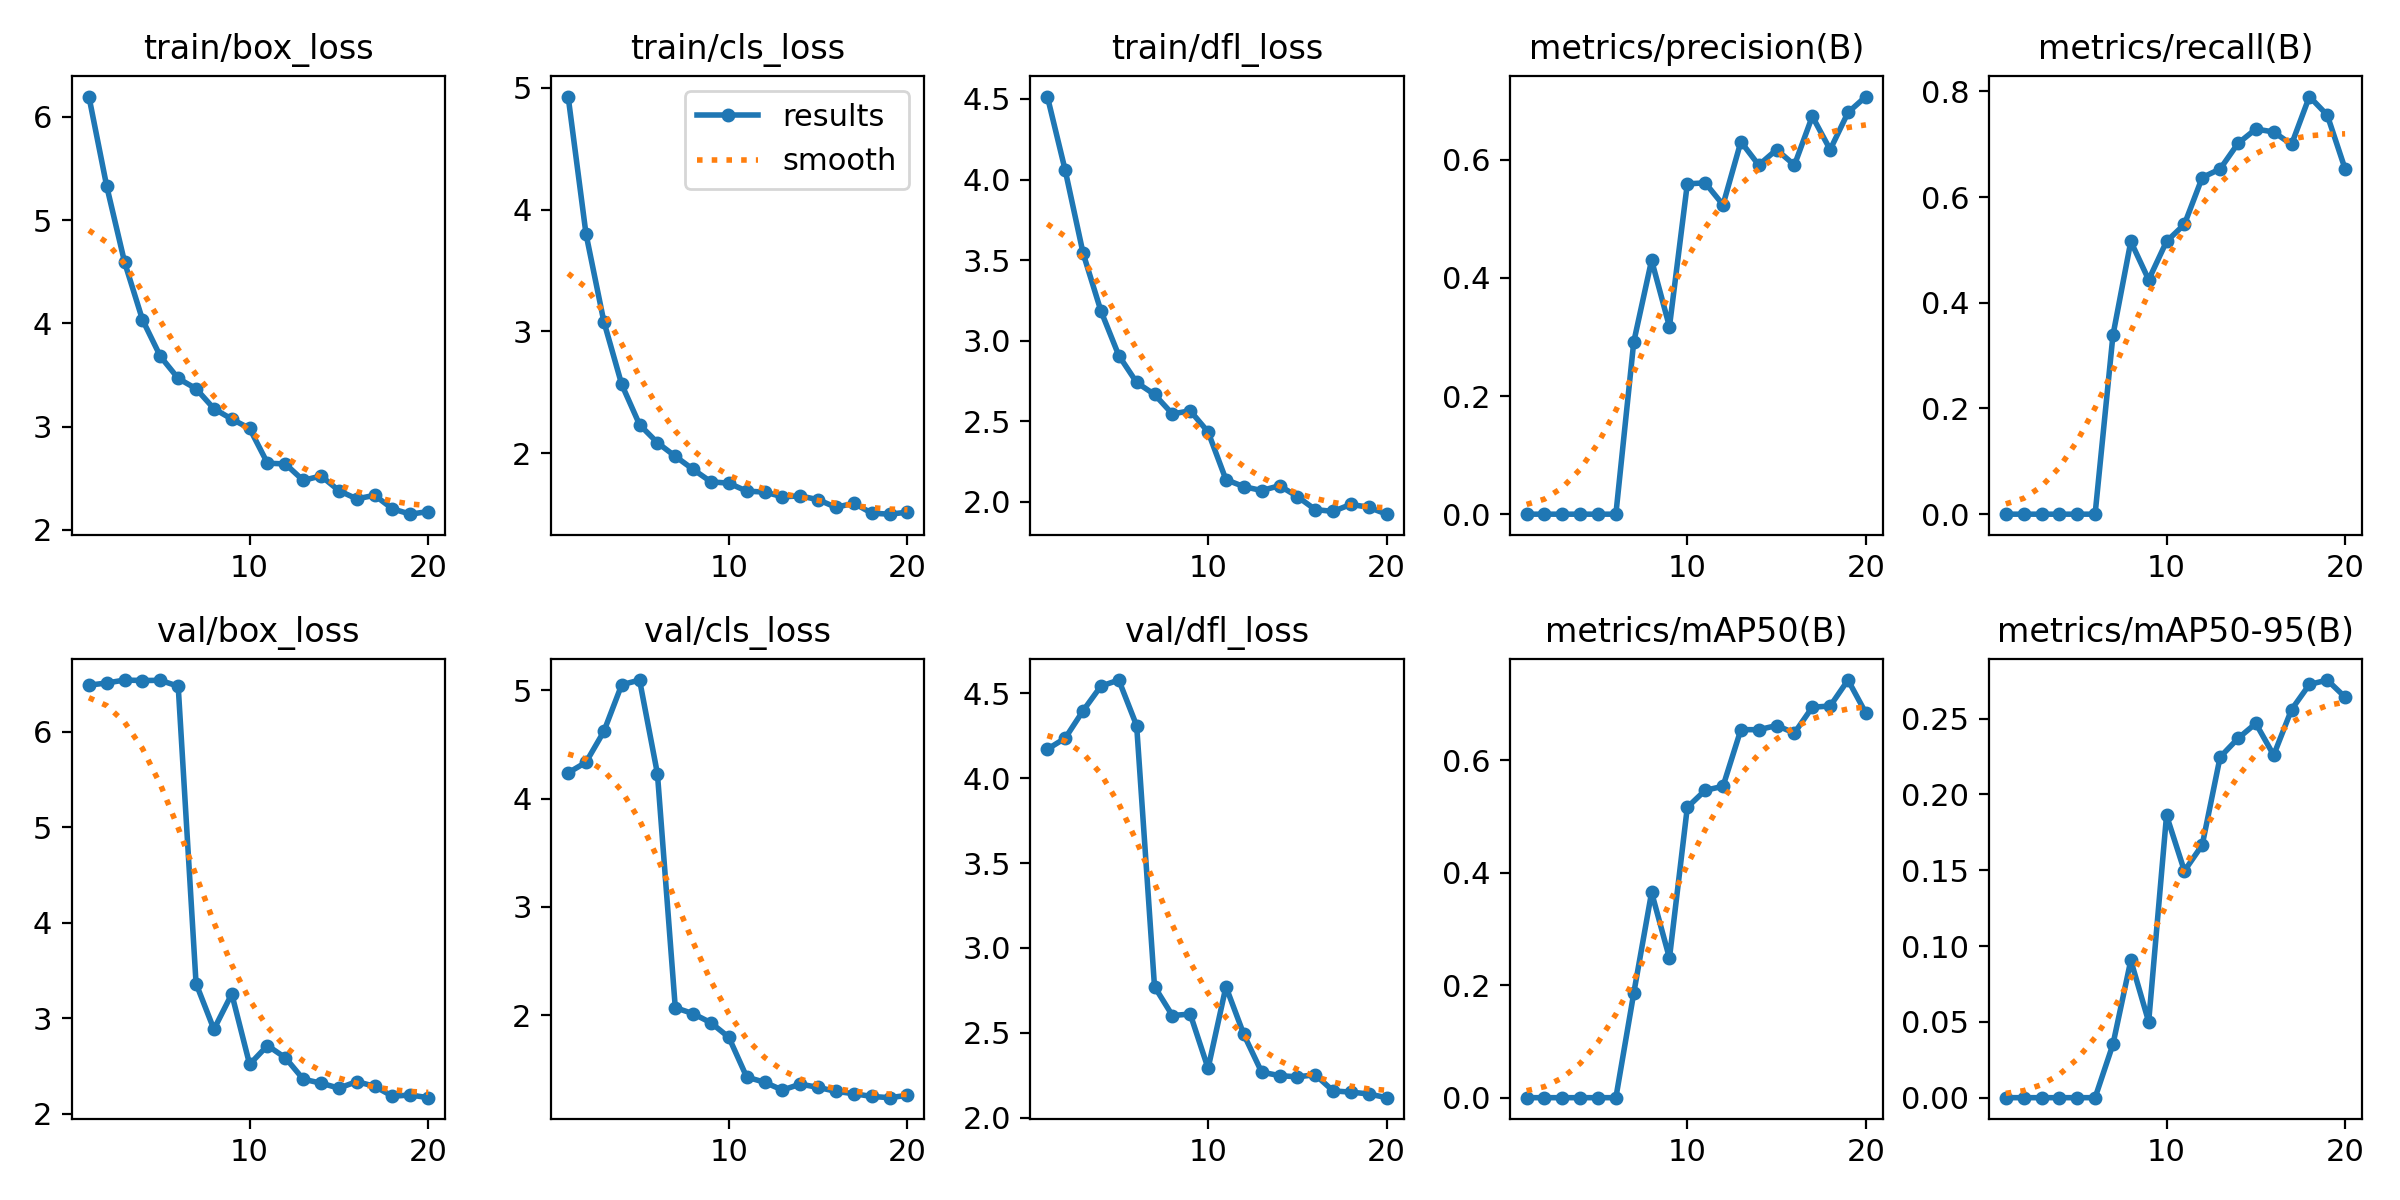

In [ ]:
Image(filename=f'{HOME}/train/runs/detect/train/results.png', width=1000)

In [25]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

ds.classes

['plates']

In [26]:
from supervision.metrics import MeanAveragePrecision

model = YOLO('runs/detect/train2/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [27]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.23241993024090712
mAP 50 0.669388904772981
mAP 75 0.06556778395669603


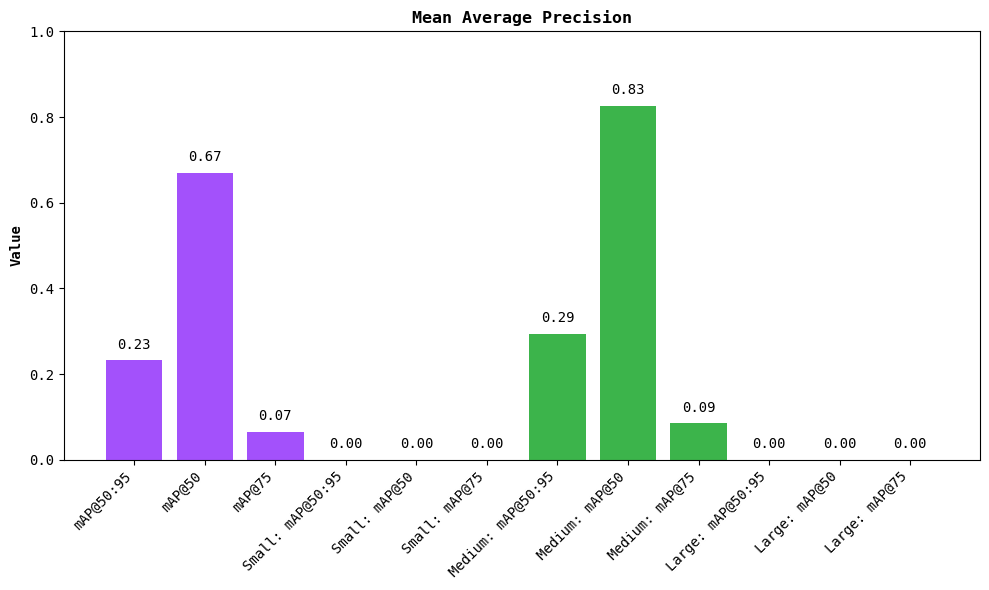

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt

map.plot()
plt.show()


## Run inference with fine-tuned YOLOv12 model

In [29]:

from PIL import Image, ImageOps
model = YOLO('runs/detect/train2/weights/best.pt')
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

In [30]:
def histogram_equalization(image):
    """
    ทำ Histogram Equalization บนช่อง Value (V) ของภาพ HSV
    """
    # แปลงจาก RGB เป็น HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # แยกช่อง Hue, Saturation, Value
    h, s, v = cv2.split(hsv)

    # ทำ Histogram Equalization บนช่อง V (ความสว่าง)
    v_eq = cv2.equalizeHist(v)

    # รวมกลับเป็น HSV
    hsv_eq = cv2.merge([h, s, v_eq])
    # แปลงกลับเป็น RGB
    image_eq = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB)

    return image_eq

def white_balance_simple(image):
    """
    Simple white balance by scaling channels based on average intensity
    """
    # Convert to float for calculations
    image_float = image.astype(np.float32)

    # Calculate the mean for each channel
    mean_r = np.mean(image_float[:,:,0])
    mean_g = np.mean(image_float[:,:,1])
    mean_b = np.mean(image_float[:,:,2])

    # Calculate scaling factors
    scale_r = 128 / mean_r if mean_r > 0 else 1
    scale_g = 128 / mean_g if mean_g > 0 else 1
    scale_b = 128 / mean_b if mean_b > 0 else 1

    # Scale each channel
    image_float[:,:,0] *= scale_r
    image_float[:,:,1] *= scale_g
    image_float[:,:,2] *= scale_b

    # Clip values to valid range
    image_balanced = np.clip(image_float, 0, 255).astype(np.uint8)

    return image_balanced

def white_balance_gray_world(image):
    """
    Gray World Assumption white balance method
    """
    # Convert to float for calculations
    image_float = image.astype(np.float32)

    # Calculate average of each channel
    r_avg = np.mean(image_float[:,:,0])
    g_avg = np.mean(image_float[:,:,1])
    b_avg = np.mean(image_float[:,:,2])

    # Calculate the overall average
    avg = (r_avg + g_avg + b_avg) / 3

    # Calculate scaling factors
    r_scale = avg / r_avg if r_avg > 0 else 1
    g_scale = avg / g_avg if g_avg > 0 else 1
    b_scale = avg / b_avg if b_avg > 0 else 1

    # Apply scaling
    image_float[:,:,0] *= r_scale
    image_float[:,:,1] *= g_scale
    image_float[:,:,2] *= b_scale

    # Clip values to valid range
    image_balanced = np.clip(image_float, 0, 255).astype(np.uint8)
    return image_balanced

In [31]:
def detect_color_from_bbox(image, bbox, crop_ratio=0.8):
    """
    Detect average color from bounding box using advanced color analysis

    Args:
    - image: PIL Image
    - bbox: (xmin, ymin, xmax, ymax)
    - crop_ratio: Ratio of bounding box to analyze (default 0.8)

    Returns:
    - Tuple of (hue, saturation, value)
    """
    xmin, ymin, xmax, ymax = bbox
    cropped_img = image.crop((xmin, ymin, xmax, ymax))
    cropped_img = np.array(cropped_img)

    # Convert to HSV
    hsv_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2HSV)

    # Apply median blur to reduce noise
    hsv_img = cv2.medianBlur(hsv_img, 5)

    # Crop center of the image
    h, w, _ = hsv_img.shape
    new_h, new_w = int(h * crop_ratio), int(w * crop_ratio)
    y_offset, x_offset = (h - new_h) // 2, (w - new_w) // 2
    cropped_center = hsv_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w]

    # Calculate median values
    avg_hue = np.median(cropped_center[:, :, 0])
    avg_sat = np.median(cropped_center[:, :, 1])
    avg_val = np.median(cropped_center[:, :, 2])

    return avg_hue, avg_sat, avg_val

def identify_color(avg_hue, avg_sat, avg_val):
    """
    Identify color based on HSV values

    Args:
    - avg_hue: Hue value (0-180 in OpenCV)
    - avg_sat: Saturation value (0-255)
    - avg_val: Value/Brightness value (0-255)

    Returns:
    - Color name as string
    """
    # Convert OpenCV HSV to standard HSV
    hue = avg_hue * 2  # OpenCV uses 0-180, standard HSV uses 0-360
    sat = avg_sat / 255 * 100  # Convert to percentage
    val = avg_val / 255 * 100  # Convert to percentage

    # Print debug information
    print(f"🔍 Hue: {hue:.2f}, Saturation: {sat:.2f}%, Value: {val:.2f}%")

    # Check for white, black, or gray conditions
    if val < 20:
        return "Black"
    if sat < 20 or val > 90:
        return "White"

    # Detailed color mapping
    if (hue >= 330 or hue <= 30):  # Red
        return "Red"
    elif 30 < hue < 90:  # Yellow to Green
        if hue < 60:
            return "Yellow"
        else:
            return "Green"
    elif 90 <= hue < 150:  # Cyan to Blue
        if hue < 120:
            return "Cyan"
        else:
            return "Blue"
    elif 150 <= hue < 270:  # Blue to Purple
        if hue < 210:
            return "Blue"
        else:
            return "Purple"
    elif 270 <= hue < 330:  # Magenta to Red
        return "Red2"

    return "Unknown"

In [39]:
# Main processing function
def process_image(image_path, model, sv):
    # Open and preprocess image
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    image = Image.fromarray(white_balance_gray_world(np.array(image)))

    # Detect objects
    results = model(image, verbose=False)[0]
    # ปรับค่า IoU threshold ในขั้นตอน NMS
    detections = sv.Detections.from_ultralytics(results).with_nms()


    # Annotate image
    box_annotator = sv.BoxAnnotator(thickness=1)
    label_annotator = sv.LabelAnnotator()
    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Count colors
    dict_count = {}
    for i, box in enumerate(detections.xyxy):
        avg_color = detect_color_from_bbox(image, box)
        color = identify_color(*avg_color)

        # Count colors
        dict_count[color] = dict_count.get(color, 0) + 1

    # Print results
    for key, value in dict_count.items():
        print(f"{key}: {value}")

    print(f"Number of detections: {len(detections.xyxy)}")
    print(f"Number of boxes drawn: {len(detections)}")

    # Plot image
    sv.plot_image(annotated_image)

    return dict_count, annotated_image

# Call the processing function

# result_count, result_image = process_image(image_path, model, sv)

## predict your picture

🔍 Hue: 198.00, Saturation: 12.55%, Value: 51.37%
🔍 Hue: 356.00, Saturation: 81.96%, Value: 35.29%
🔍 Hue: 170.00, Saturation: 5.88%, Value: 48.63%
🔍 Hue: 150.00, Saturation: 5.49%, Value: 41.57%
🔍 Hue: 356.00, Saturation: 50.98%, Value: 75.29%
🔍 Hue: 196.00, Saturation: 12.55%, Value: 95.29%
🔍 Hue: 346.00, Saturation: 78.04%, Value: 29.80%
White: 4
Red: 3
Number of detections: 7
Number of boxes drawn: 7


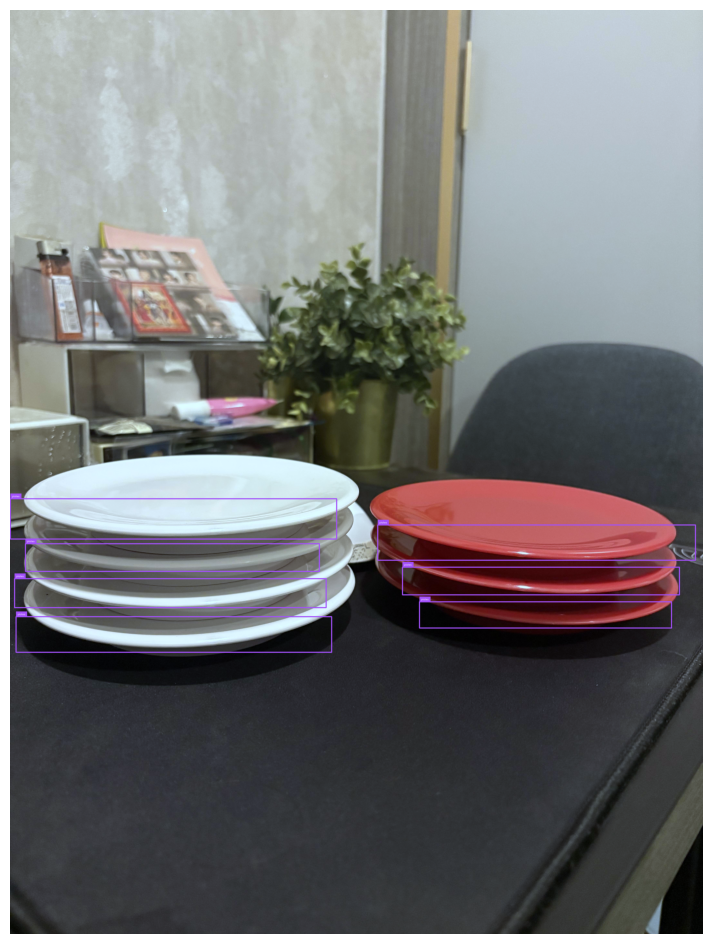

In [ ]:
#select your picture to predict
image_path = "c:\\Manus\\DL_project\\project\\3.jpg"
result_count, result_image = process_image(image_path, model, sv)

## predict dataset test

🔍 Hue: 330.00, Saturation: 67.06%, Value: 41.57%
🔍 Hue: 346.00, Saturation: 66.67%, Value: 34.51%
🔍 Hue: 342.00, Saturation: 78.63%, Value: 30.39%
🔍 Hue: 299.00, Saturation: 23.53%, Value: 36.47%
🔍 Hue: 348.00, Saturation: 74.90%, Value: 35.29%
🔍 Hue: 210.00, Saturation: 25.49%, Value: 50.59%
🔍 Hue: 346.00, Saturation: 80.98%, Value: 24.31%
🔍 Hue: 348.00, Saturation: 89.80%, Value: 20.78%
🔍 Hue: 344.00, Saturation: 81.18%, Value: 23.92%
🔍 Hue: 208.00, Saturation: 23.14%, Value: 46.67%
🔍 Hue: 330.00, Saturation: 82.75%, Value: 23.53%
🔍 Hue: 210.00, Saturation: 21.96%, Value: 41.57%
🔍 Hue: 210.00, Saturation: 22.35%, Value: 43.53%
🔍 Hue: 208.00, Saturation: 21.96%, Value: 41.57%
Red: 8
Red2: 1
Purple: 3
Blue: 2
Number of detections: 14
Number of boxes drawn: 14


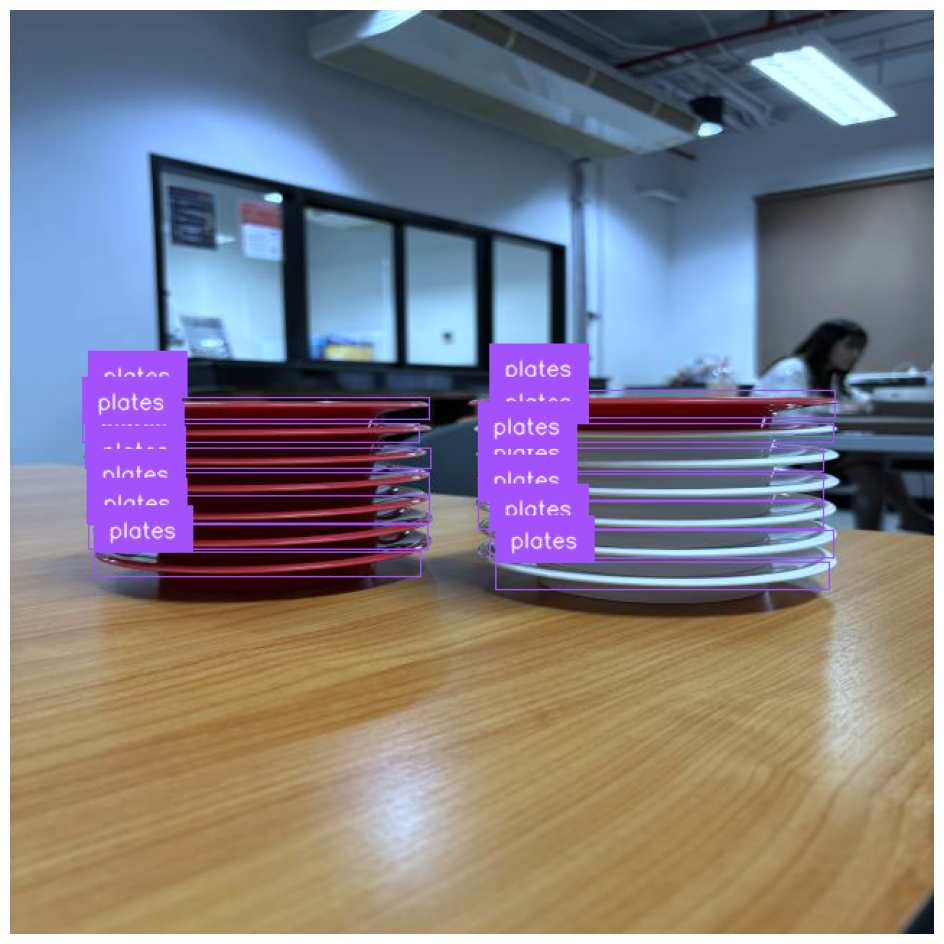

In [49]:
i = random.randint(0, len(ds))

image_path, image, target = ds[i]

result_count, result_image = process_image(image_path, model, sv)